In [1]:
# Libraries 
#options(repr.plot.width= 5, repr.plot.height=14)
options(warn=-1)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(psych))
suppressPackageStartupMessages(library(GGally))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(PerformanceAnalytics))
suppressPackageStartupMessages(library(foreach))
suppressPackageStartupMessages(library(glmnet))
suppressPackageStartupMessages(library(AER))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(rstatix))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(caret))
suppressPackageStartupMessages(library(knitr))
suppressPackageStartupMessages(library(ggcorrplot))
suppressPackageStartupMessages(library(MASS))
suppressPackageStartupMessages(library(cvms))
suppressPackageStartupMessages(library(pscl))
suppressPackageStartupMessages(library(mpath))
suppressPackageStartupMessages(library(data.table))

# Group 2 Final Report: Modelling the DoctorVisits dataset

# Introduction 

Predicting the number of visits made to a doctor based on patient-specific attributes has tremendous significance for identifying factors that may have a relationship with seeking medical attention. Patient-specific attributes can fall into any of three broad categories: demographic attributes (such as age, gender, etc.), medical attributes (severity of illness, general health etc.) and the availability of insurance (the latter of which is much more important in countries that function on a private health insurance-based system). 

These attributes are very likely to correlate with the number of visits made. However, the predictive value of such variables has not been suffiently explored and exploited to its potential. Such data based on patient visitations is very prone to zero-inflation due to sampling zeroes, in the case of which prediction is generally a challenge. Thus, it is imperative to 1) identify important variables that show a relationship with the number of visits and 2) build a correctly specified prediction model that is capable of predicting the number of doctor visits in the case of zero-inflation. 

In this report, we discuss the methodology used to accomplish these steps. Specifically, the two endpoints of this project are 1) identifying the patient-specific attributes that can explain the outcome (the number of visits) and 2) Building a well-specified prediction model for the number of doctor visits. 

# Methods 

## Dataset Overview

For our project we use the *DoctorVisits* dataset sourced from the AER package. This dataset was collected for a cross-sectional study through the Australian Health Survey in 1977-1978. Our response variable of interest is the number of doctor visits in past 2 weeks (`visits`). This is a variable of counts, ranging from 0-9 visits. It consists of 5190 observations on 11 variables, which were thought to influence the number of visits paid to a doctor. The 11 variables are as follows:

- `gender`: Factor indicating gender (categorical: female/male)
-  `age`: Age in years divided by 100 (numeric)
- `income` : Annual income in tens of thousands of dollars (numeric)
- `illness` : Number of illnesses in past 2 weeks (numeric)
- `reduced` : Number of days of reduced activity in past 2 weeks due to illness or injury (numeric)
- `health` : General health questionnaire score using Goldberg's method (numeric)
- `private` : Does the individual have private health insurance? (categorical: yes/no)
- `freepoor` : Does the individual have free government health insurance due to low income (categorical: yes/no)
- `freerepat`: Does the individual have free government health insurance due to old age, disability or veteran status? (categorical: yes/no)
- `nchronic`: Is there a chronic condition not limiting activity? (categorical: yes/no)
- `lchronic`: Is there a chronic condition limiting activity? (categorical: yes/no)



## Exploratory Data Analysis

In our exploratory data analysis, we are interested in exploring: 

- The observed distribution of our response variable
- Whether any of the covariates appear to have an evident relationship with the response variable
- Whether any of the covariates are highly correlated with each other 
- Potential overdispersion
- Any other evident patterns/trends unique to the dataset

The first 6 rows of the DoctorVisits dataset look as follows: 

In [2]:
data("DoctorVisits")
full.data <- get("DoctorVisits")
head(full.data)

,visits,gender,age,income,illness,reduced,health,private,freepoor,freerepat,nchronic,lchronic
,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,female,0.19,0.55,1,4,1,yes,no,no,no,no
2,1,female,0.19,0.45,1,2,1,yes,no,no,no,no
3,1,male,0.19,0.90,3,0,0,no,no,no,no,no
4,1,male,0.19,0.15,1,0,0,no,no,no,no,no
5,1,male,0.19,0.45,2,5,1,no,no,no,yes,no
6,1,female,0.19,0.35,5,1,9,no,no,no,yes,no


## Exploring the response variable

The observed distribution of our response variable is as follows: 

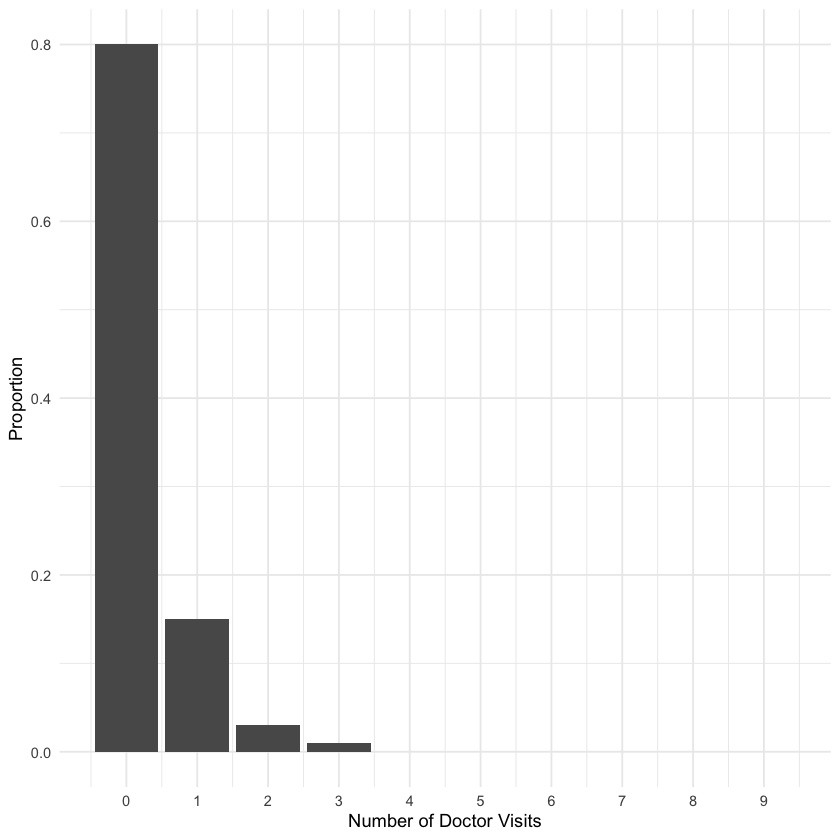

In [3]:
length <- nrow(full.data)
plot.data <- full.data %>%
    group_by(visits) %>%
    summarise(n = n()) %>%
    mutate(proportion = round(n/length,2))
plot.data %>%
  ggplot(aes(x= visits, y = proportion)) +
    geom_bar(stat = "identity") + 
    theme_minimal() +
    scale_x_continuous(breaks= pretty_breaks(n=9)) + 
  labs(x = "Number of Doctor Visits", y = "Proportion")

We see that our response variable follows a heavily skewed distribution. It is zero-inflated with 80% of the observations being zero values. We can  further look at the raw counts in each of the outcome categories (which range from 0-9)

In [4]:
table(full.data$visits)


   0    1    2    3    4    5    6    7    8    9 
4141  782  174   30   24    9   12   12    5    1 

It is evident that there are very patients for which the number of visits is 5 and above. Specifically, we notice that there is only one observation with 9 visits. It is important to notice and account for this in our training and test split, as this is likely to reduce prediction power. 

## Summary statistics: exploring missing values and overdispersion

In [5]:
# Summary statistics 
get_summary_stats(full.data) 

variable,n,min,max,median,q1,q3,iqr,mad,mean,sd,se,ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
age,5190,0.19,0.72,0.32,0.22,0.62,0.40,0.193,0.406,0.205,0.003,0.006
health,5190,0.00,12.00,0.00,0.00,2.00,2.00,0.000,1.218,2.124,0.029,0.058
illness,5190,0.00,5.00,1.00,0.00,2.00,2.00,1.483,1.432,1.384,0.019,0.038
income,5190,0.00,1.50,0.55,0.25,0.90,0.65,0.445,0.583,0.369,0.005,0.010
reduced,5190,0.00,14.00,0.00,0.00,0.00,0.00,0.000,0.862,2.888,0.040,0.079
visits,5190,0.00,9.00,0.00,0.00,0.00,0.00,0.000,0.302,0.798,0.011,0.022


From the following summary statistics table (column n), we see that none of the variables have any missing observations. 

Looking at the `visits` variable, we see that while the mean is 0.302, the variance is $0.798^2$ which is 0.637. The variance is marginally higher than the mean here. This marginal difference may not necessarily indicate overdispersion, but exploring this through the use of a negative binomial model may be necessary to confirm this.

## Exploring the association of the categorical variables with the Number of Doctor Visits

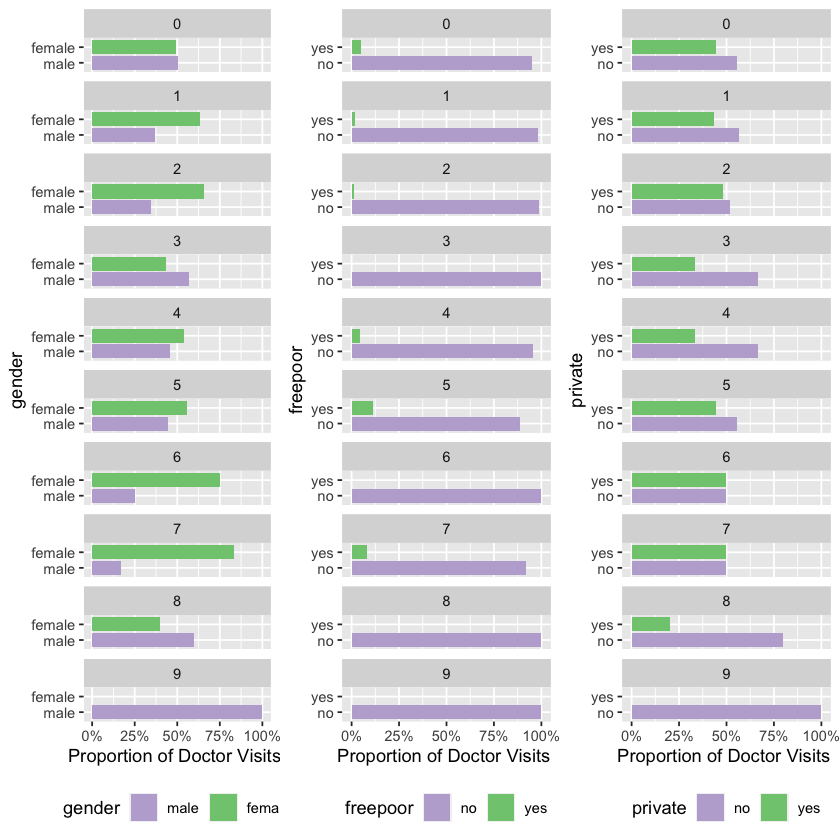

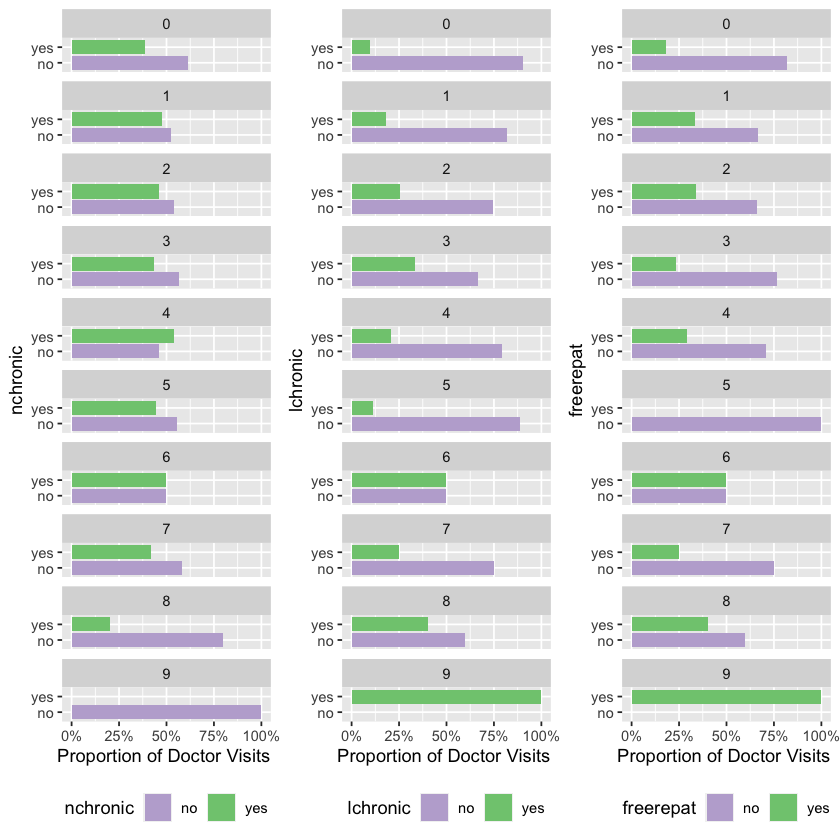

In [6]:
full.data$y <- as.factor(full.data$visits)

p1 <- full.data %>%
  count(gender, y) %>%
  left_join(full.data %>% count(y, name = "m"), by = "y") %>%
  mutate(proportion = n/m) %>%
  ggplot(aes(x = gender, y = proportion, fill = gender)) +
  geom_col(position = "stack") + 
  facet_wrap(~y, ncol =1) +
  scale_fill_brewer(type="qual", direction=-1) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) + 
    labs(y=paste("Proportion of Doctor Visits", x=""))

p2 <- full.data %>%
  count(freepoor, y) %>%
  left_join(full.data %>% count(y, name = "m"), by = "y") %>%
  mutate(proportion = n/m) %>%
  ggplot(aes(x = freepoor, y = proportion, fill = freepoor)) +
  geom_col(position = "stack") + 
  facet_wrap(~y, ncol =1) +
  scale_fill_brewer(type="qual", direction=-1) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) + 
    labs(y=paste("Proportion of Doctor Visits", x=""))

p3 <- full.data %>%
  count(private, y) %>%
  left_join(full.data %>% count(y, name = "m"), by = "y") %>%
  mutate(proportion = n/m) %>%
  ggplot(aes(x = private, y = proportion, fill = private)) +
  geom_col(position = "stack") + 
  facet_wrap(~y, ncol =1) +
  scale_fill_brewer(type="qual", direction=-1) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) + 
    labs(y=paste("Proportion of Doctor Visits", x=""))

p4 <- full.data %>%
  count(nchronic, y) %>%
  left_join(full.data %>% count(y, name = "m"), by = "y") %>%
  mutate(proportion = n/m) %>%
  ggplot(aes(x = nchronic, y = proportion, fill = nchronic)) +
  geom_col(position = "stack") + 
  facet_wrap(~y, ncol =1) +
  scale_fill_brewer(type="qual", direction=-1) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) + 
    labs(y=paste("Proportion of Doctor Visits", x=""))

p5 <- full.data %>%
  count(lchronic, y) %>%
  left_join(full.data %>% count(y, name = "m"), by = "y") %>%
  mutate(proportion = n/m) %>%
  ggplot(aes(x = lchronic, y = proportion, fill = lchronic)) +
  geom_col(position = "stack") + 
  facet_wrap(~y, ncol =1) +
  scale_fill_brewer(type="qual", direction=-1) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) + 
    labs(y=paste("Proportion of Doctor Visits", x=""))

p6 <- full.data %>%
  count(freerepat, y) %>%
  left_join(full.data %>% count(y, name = "m"), by = "y") %>%
  mutate(proportion = n/m) %>%
  ggplot(aes(x = freerepat, y = proportion, fill = freerepat)) +
  geom_col(position = "stack") + 
  facet_wrap(~y, ncol =1) +
  scale_fill_brewer(type="qual", direction=-1) +
  coord_flip() +
  scale_y_continuous(labels = scales::percent) + 
    labs(y=paste("Proportion of Doctor Visits", x=""))

ggpubr::ggarrange(p1, p2, p3,  ncol= 3, nrow= 1,  legend="bottom")
ggpubr::ggarrange(p4, p5, p6,  ncol= 3, nrow= 1, legend="bottom")

From these plots, `gender` may influence the number of visits, as compared to males, a greater proportion of females seem to make a higher number of visits. 
The variables `freepoor` and `private` do not seem to have any clear relationship with the proportion of doctor visits. We do see some indications 
that the `freerepat` variable may be important, as having the special old age insurance does seem to lead to visiting the doctor an increased number of times. 
Having a chronic condition, whether it limits (`lchronic`) or does not limit (`nchronic`) activity both seem 
to be an important variables, as the number of doctor visits seems to comparatively increase with both the `nchronic`and `lchronic` variable. 

In general, the proportions decrease as the number of visits increase for all the variables. In particular, at the highest count (9), a large proportion of the patients are male, have free special insurance (`freerepat`), and have chronic conditions, and such, these categorical variables are likely important for predicting larger counts 



We can further explore the distribution of counts of the response variable across the categorical variables. 

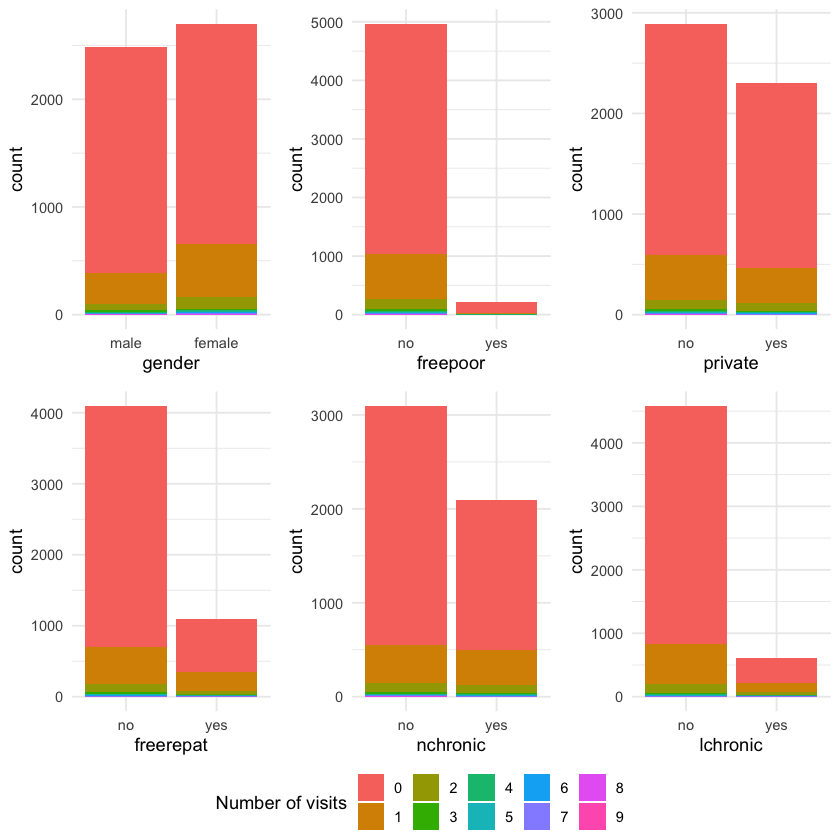

In [7]:
# Stackplots for categorical variables
gender<-full.data%>%
 ggplot() + 
 geom_bar(aes(x = gender, fill = as.factor(visits)))+
 theme_minimal() + labs(fill = "Number of visits")
private<-full.data%>%
 ggplot() + 
 geom_bar(aes(x = private, fill = as.factor(visits)))+
 theme_minimal() + labs(fill = "Number of visits")
freepoor<-full.data%>%
 ggplot() + 
 geom_bar(aes(x = freepoor, fill = as.factor(visits)))+
 theme_minimal() + labs(fill = "Number of visits")
freerepat<-full.data%>%
 ggplot() + 
 geom_bar(aes(x = freerepat, fill = as.factor(visits)))+
 theme_minimal() + labs(fill = "Number of visits")
nchronic<-full.data%>%
 ggplot() + 
 geom_bar(aes(x = nchronic, fill = as.factor(visits)))+
 theme_minimal() + labs(fill = "Number of visits")
lchronic<-full.data%>%
 ggplot() + 
 geom_bar(aes(x = lchronic, fill = as.factor(visits)))+
 theme_minimal() + labs(fill = "Number of visits")

ggpubr::ggarrange(gender, freepoor, private, freerepat, nchronic,
                  lchronic, ncol=3, nrow=2, common.legend = TRUE, legend="bottom")

We see that males and females are quite evenly represented in the data, with marginally more females than males. This holds true for people who have and do not have private insurance as well (`private`), with a marginally greater amount of patients haveing no private insurance. The majority of patients do not have free governmental insurance due to low income (`freepoor`). A larger number of patients do not have any chronic conditions in general. There is a larger disparity in patients that do have chronic conditions that limit activity compared to patients that do not, with a very small number of patients having chronic conditions that do limit activity, but a moderate number having chronic conditions that do not limit activity. This could explain the large proportion of the zeroes evident in our response, as the latter patients are likely less prone to visit the hospital. 


## Exploring the associations of the continuous variables with the number of Doctor Visits

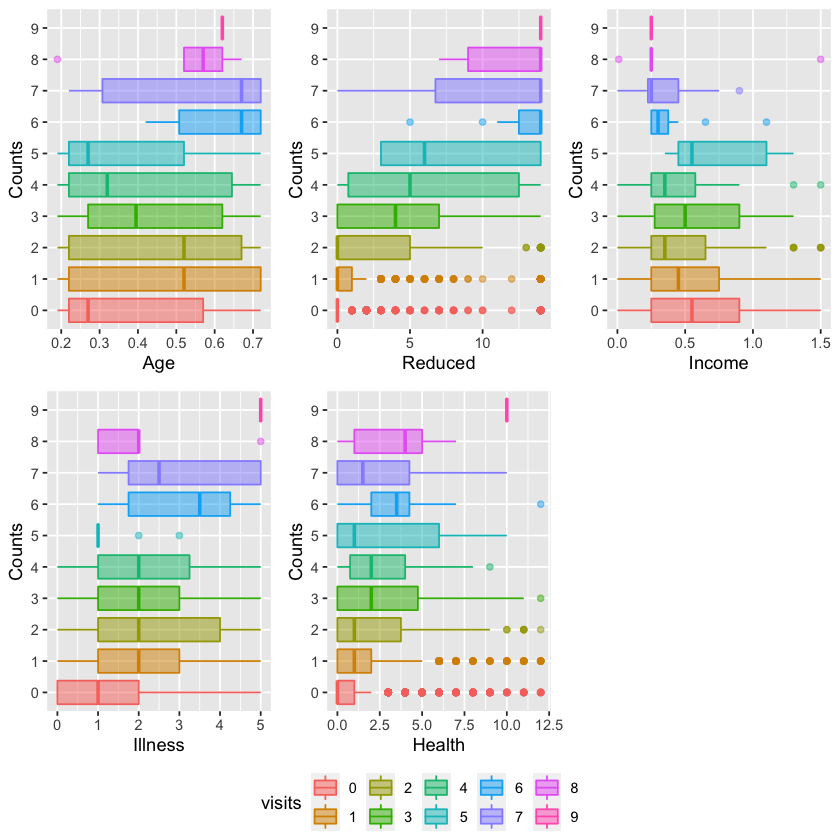

In [8]:
# Converting to factor for plot
full.data$visits <- factor(full.data$visits)

 p5 <- ggplot(full.data, aes(age, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5) + 
  labs(x = "Age", y = "Counts")
p6 <- ggplot(full.data, aes(reduced, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5) + 
  labs(x = "Reduced", y = "Counts")
p7 <- ggplot(full.data, aes(income, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5) + 
  labs(x = "Income", y = "Counts")
p8 <- ggplot(full.data, aes(illness, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5)  + 
  labs(x = "Illness", y = "Counts")
p9 <- ggplot(full.data, aes(health, visits)) + geom_boxplot(aes(colour = visits, fill = visits), alpha = 0.5)  + 
 labs(x = "Health", y = "Counts")

ggpubr::ggarrange(p5, p6, p7, p8, p9, ncol=3, nrow=2, common.legend = TRUE, legend="bottom")

`Age` is likely an important explanatory variable, there does seem to be a somewhat of an increasing number of doctor visits with increasing age (although this is hard to tell for some of the counts in the middle). In the boxplots for the `reduced` variable, we almost see an increasing trend between the number of visits and number of reduced days as well, which we expect. However, a clear trend is not evident due to the excess zeroes, which emphasizes the need for a zero-inflated model.  This trend holds true for the `Illness` variable as well, where the mean number of illnesses seems to increase along with higher doctor visits. There is no clear relationship between the number of visits and `income`, as well as `health` as neither necessarily appear to increase or decrease for a higher number of visits.  

## Relationships between the covariates

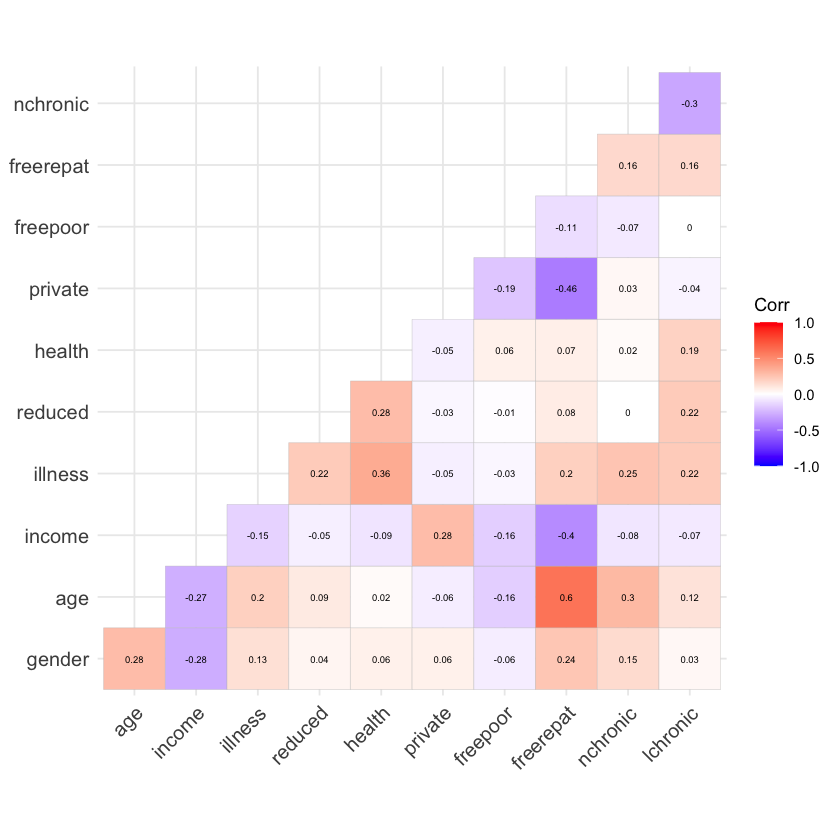

In [9]:
full.data<-full.data%>%
 mutate(gender=if_else(gender=="male",0,1))%>%
 mutate(private=if_else(private=="no",0,1))%>%
 mutate(freepoor=if_else(freepoor=="no",0,1))%>%
 mutate(freerepat=if_else(freerepat=="no",0,1))%>%
 mutate(nchronic=if_else(nchronic=="no",0,1))%>%
 mutate(lchronic=if_else(lchronic=="no",0,1))
model.matrix(~0+., data = full.data %>% dplyr::select(-y, -visits)) %>% 
  cor(use="pairwise.complete.obs") %>% 
  ggcorrplot(show.diag = F, type="lower", lab=TRUE, lab_size=2)

In terms of relationships between the covariates, there do not seem to be any particularly strong relationships between covariates with the exception of `Age`, and having specialized old age insurance (`freerepat`) which is expected. There do seem to be some moderate correlations between variables, such as between `health` and `insurance`, and a negative correlation between `private` and `freerepat`, as well as between `income` and `freerepat`.

Since some of the variables have different types (numeric and binary), the Pearson's correlation would not be accurate. Therefore, we will use point-biserial and tetrachronic correlations to see more accurate estimates of the correlation between categorical variables 

#### Tetrachronic

In [10]:
is_binary <- function(x) all(unique(x) %in% c(0, 1))
binary_matrix <- full.data %>%
    select_if(is_binary)
tetrachr_matrix <- binary_matrix %>%
    mutate_all(as.factor) 
tetrachr_matrix <- data.matrix(tetrachr_matrix)
tetrachoric(tetrachr_matrix)

Call: tetrachoric(x = tetrachr_matrix)
tetrachoric correlation 
          gendr privt frepr frrpt nchrn lchrn
gender     1.00                              
private    0.04  1.00                        
freepoor  -0.19 -0.51  1.00                  
freerepat  0.33 -0.58 -0.39  1.00            
nchronic   0.25  0.01 -0.22  0.21  1.00      
lchronic   0.07 -0.13 -0.04  0.24 -0.86  1.00

 with tau of 
   gender   private  freepoor freerepat  nchronic  lchronic 
   -0.052     0.144     1.719     0.806     0.245     1.192 

#### Point-biserial

In [33]:
numeric_matrix <- full.data %>%
    dplyr::select(-y) %>%
    select_if(Negate(is_binary)) %>%
    mutate_all(as.numeric)
biserial_matrix <- matrix(, nrow = ncol(binary_matrix), ncol = ncol(numeric_matrix))
for(i in 1:ncol(numeric_matrix)){
    for(j in 1:ncol(binary_matrix)){
        biserial_matrix[i,j]<-biserial(numeric_matrix[,i],binary_matrix[,j])[1]
    }
}
colnames(biserial_matrix) <- colnames(numeric_matrix)
rownames(biserial_matrix) <- colnames(binary_matrix)
biserial_matrix

,visits,age,income,illness,reduced,health
gender,0.09859467,-0.01001824,-0.08486371,0.15052647,0.05723115,0.2247443
private,0.35248907,-0.07183308,-0.35921923,0.85450149,0.37491755,0.1982161
freepoor,-0.34680962,0.34921264,-0.35906494,-0.56870754,-0.09860119,-0.1072188
freerepat,0.16903043,-0.05877257,-0.05798474,0.28562785,0.31079320,0.3612876
nchronic,0.05146346,-0.03760711,-0.01490944,0.11840557,-0.00258372,0.3546257
lchronic,0.07199274,-0.06338002,0.12830592,0.09645898,0.02809813,0.3130459


We can see there is a quite high association between the `nchronic` and `lchronic` (in terms of tetrachronic correlation), and between `private` and `illness` (in terms of point-biserial correlation). Since Elastic Net uses a combination of Lasso and Ridge penalties, the Lasso part can control for possible multicollinerarity by shrinking one of the correlated predictors

## Techniques Used

The main question we hope to answer with this project is: 

##### Can the number of doctor visits be predicted using demographic variables, insurance status measures and chronic conditions of a patient?

We hope to build a well-specified prediction model using a generalized linear model framework. Some methodological questions we hope to answer in building our prediction model are as follows: 

1. For this dataset, does using a negative binomial model compared to a Poisson provide a better fit by accounting for overdispersion?
2. How does a zero-inflated model compare to a regular Poisson model?
3. Which elastic net mixing parameter $\alpha$ results in the model with the lowest mean absolute error?

## Data Preparation 

For the purpose of prediction and for performing variable selection (mentioned below), we divide our data into an 80/20 split. 80% of the data will thus be used to train the model, which includes performing variable selection. The other 20% will be used to test the performance of our model. This will be done via a stratified split, in order to maintain as best as possible, the original proportion of counts in both datasets to ensure high predictive performance.

## Generalized Linear Models

As our response data is composed of counts, the number of doctor visits can be modeled assuming a Poisson error distribution. 

### Overdispersion

A common issue in modeling such count data is overdispersion, where the variance of the response is much higher than expected by the data generation process. In our exploratory analysis, we saw potential indications of overdispersion, as the variance of the number of doctor counts was marginally higher than the mean. To address this issue, we will be supplementing our Poisson model with a negative binomial model and comparing fit. The dispersion that the negative binomial model estimates will allow us to understand if overdispersion is present. 

### Zero-inflation

As evident in our exploratory analysis, 80% of our response observations are zeroes. Thus, our data is likely zero-inflated, for which just a Poisson model may not be sufficient. A zero-inflation process also makes sense in light of the data generation process, as we see from our exploratory analyses that many patients did not have private insurance, which indicates that some of the zeroes may be "sampling zeroes". We will thus employ the use of a zero-inflated model. In particular, we will compare the performance of our Poisson and negative binomial model to a zero-inflated Poisson model.


## Variable selection 

Our exploratory analyses indicate that `age`, `reduced`, `gender`, `Illness`, `freerepat`, `nchronic` and `lchronic` seem to be important explanatory variables that show some relationship with the number of visits. However, with 9 categories of counts for our response and 11 covariates, data exploration is complicated. In particular, it is hard to see clear indications of which variables may be relatively more important in predicting the number of visits. Additionally, from our correlation matrix, we do see some moderately strong correlations, such as between `age` and `freerepat` yes for instance, which both also appear to be important explanatory variables. However, including both these variables in our model may result in potential issues of collinearity.
For this reason, we plan to run penalized regression models to perform variable selection. As our categorical variables are binary, they will be included in the penalized regression model after being dummy-coded. Thus, if the dummy-variable is excluded, the entire categorical variable can be excluded easily as there are only two levels (this is not as trivial for categorical variables with multiple levels in general).

Specifically, the elastic net penalty will be used here, which can be written as follows:

$$\lambda[(1-\alpha)\|\beta \|^2_{2}/2 + \alpha\|\beta \|_{1}] $$

where $\lambda$ represents the shrinkage parameter, $\alpha$ the elastic net mixing parameter, $\|\beta \|^2_{2}$ the Ridge penalty, and $\|\beta \|_{1}$ the Lasso penalty. 

For the zero-inflated Poisson, this penalty will be applied to both the logistic and the poisson processes. Thus, there will be two shrinkage parameters: $\lambda_1$ for the logistic model and $\lambda_2$ for the poisson model. 

### Selecting the hyperparameters 

For the elastic net mixing parameter ($\alpha$), pre-defined values of 0.2, 0.5, 0.7 will be comparatively used. In essence, we are comparing $\alpha = 0.2$ which skews more towards a ridge-like regression, $\alpha = 0.5$, which evenly mixes the ridge and lasso regressions, and $\alpha = 0.7$ which skews more towards a Lasso-like regression. 

For tuning $\lambda$, 10-fold cross-validation will be used. The fold that each observation is placed in will be pre-set, in order to ensure the different values of $\alpha$ are tuned on the same folds. Specifically, the “lambda.1se” i.e the the largest $\lambda$ at which the MSE is within one standard error of the smallest MSE will be selected for.


All analyses will be performed in `R`. The stratified split will be done using the `caret` package. The Poisson and negative-binomial models will be fit with the `glmnet` package, while the penalized zero-inflated negative binomial model will be fit using the `mpath` package. The full zero-inflated poisson model will be fit with the `pscl` package.


### Model diagnostics 

During the training process, the best hyperparameters will be selected by using the Mean squared error (MSE) as the metric of model performance. The RMSE was used as it comparatively penalizes larger errors to a greater extent compared to metrics such as the Mean Absolute Error (MAE). This will be done for both the Poisson and negative-binomial models. However, for the penalized zero-inflated poisson model, the *penalized log-likelihood* will be used to select the best value of $\lambda$, as this is the standard implementation of the `mpath` package which will be used in this project.

However, **in terms of comparing predictive performance**, the Mean squared error (MSE) will be calculated and used as the comparison metric. The mis-classification error i.e the number of counts that were predicted into the wrong class will also be used as a metric to discuss the results. Lastly, a standard confusion matrix with the actual values against the predicted will be utilized to discuss the sensitivity and specificity of predictions. 

Overall, we will be comparing the predictive performance of the full and penalized models of the Poisson, Negative-Binomial and the Zero-inflated Poisson.


# Results

We first perform an approximately stratified split of the dataset using an 80/20 split. The table outputs below show the proportion of values in each count category, and verify that our split is stratified. It is important to note that our predictive model will not be able to predict the value of 9 from the test set, as there is only one count of 9.

In [263]:
set.seed(150)

# Performing a stratified split
train.index <- createDataPartition(full.data$visits, p = 0.80, list = FALSE)
train <- full.data[train.index,]
test  <- full.data[-train.index,]

# Verifying stratified split 
prop.table(table(train$visits))
prop.table(table(test$visits))

# Converting to factor
train[, c(2, 8, 9, 10, 11, 12)] <- lapply(train[, c(2, 8, 9, 10, 11, 12)], factor)
test[, c(2, 8, 9, 10, 11, 12)] <- lapply(test[, c(2, 8, 9, 10, 11, 12)], factor)


           0            1            2            3            4            5 
0.7964836224 0.1514932563 0.0334778420 0.0050578035 0.0050578035 0.0019267823 
           6            7            8            9 
0.0026493256 0.0028901734 0.0007225434 0.0002408478 


           0            1            2            3            4            5 
0.8034682081 0.1473988439 0.0337186898 0.0086705202 0.0028901734 0.0009633911 
           6            8 
0.0009633911 0.0019267823 

In [264]:
# Dummy-coding training 
design_factors <- with(train, model.matrix(visits ~ private + freepoor + freerepat + nchronic + 
                        lchronic + gender)[, -1])

x_train <- as.matrix(with(train, data.frame(age, reduced, illness, income, health, design_factors)))

# Dummy-coding test
design_factors_t <- with(test, model.matrix(visits ~ private + freepoor + freerepat + nchronic + 
                        lchronic + gender)[, -1])

x_test <- as.matrix(with(test, data.frame(age, reduced, illness, income, health, design_factors_t)))

## Poisson Model 

### Penalized Model Selection and Prediction

In [277]:
set.seed(123)
# Pre-specified folds for ten-fold cross-validation
foldid <- sample(1:10, size = nrow(train), replace = TRUE)
# CV for all-three pre-defined values of alpha
cv02 <- cv.glmnet(x_train, train$visits, foldid = foldid, alpha = 0.2, family = "poisson",
                  nfold = 10,  type.measure = "mse", keep = TRUE)
cv05 <- cv.glmnet(x_train, train$visits, foldid = foldid, alpha = 0.5, 
                 family = "poisson", nfold = 10, type.measure = "mse", keep = TRUE)
cv07  <- cv.glmnet(x_train, train$visits, foldid = foldid, alpha = 0.7, 
                  family = "poisson", nfold = 10, type.measure = "mse", keep = TRUE)

cv02 ; cv05 ; cv07


Call:  cv.glmnet(x = x_train, y = train$visits, type.measure = "mse",      nfolds = 10, foldid = foldid, keep = TRUE, alpha = 0.2, family = "poisson") 

Measure: Mean-Squared Error 

    Lambda Index Measure      SE Nonzero
min 0.1535    27  0.5598 0.03768       6
1se 0.5144    14  0.5918 0.03592       3


Call:  cv.glmnet(x = x_train, y = train$visits, type.measure = "mse",      nfolds = 10, foldid = foldid, keep = TRUE, alpha = 0.5, family = "poisson") 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.08906    23  0.5594 0.03719       4
1se 0.29851    10  0.5913 0.03538       1


Call:  cv.glmnet(x = x_train, y = train$visits, type.measure = "mse",      nfolds = 10, foldid = foldid, keep = TRUE, alpha = 0.7, family = "poisson") 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.06982    22  0.5597 0.03697       4
1se 0.25682     8  0.5948 0.03554       1

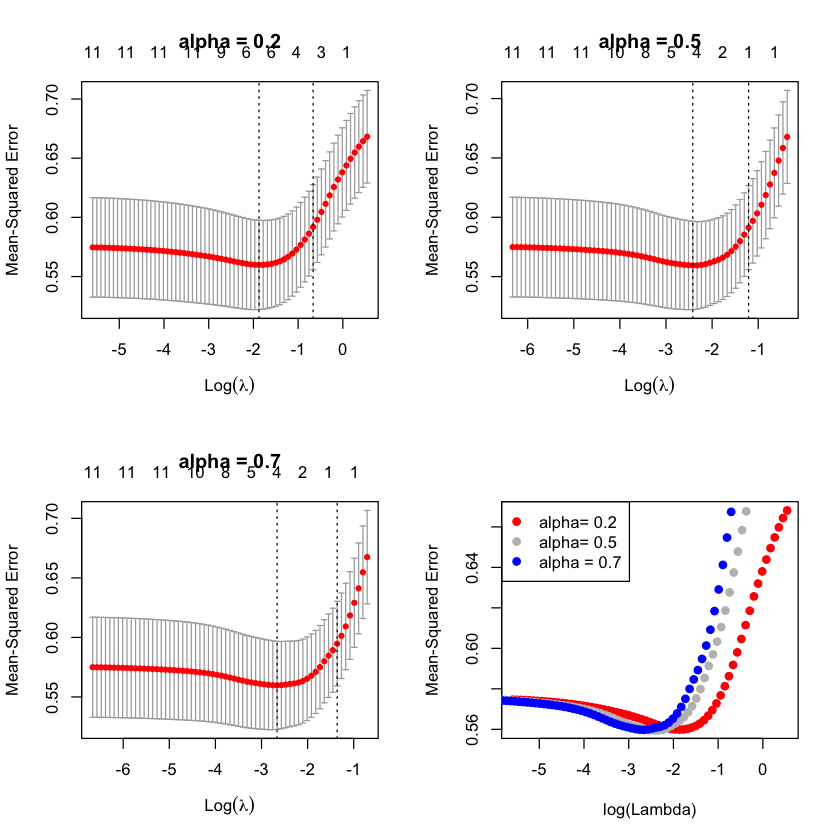

In [267]:
# Visualizing tuning of lambda for different alphas 
# Adapted directly from the glmnet vignette
par(mfrow = c(2,2))
plot(cv02, main = "alpha = 0.2"); plot(cv05, main = "alpha = 0.5"); plot(cv07, main = "alpha = 0.7")
plot(log(cv02$lambda)   , cv02$cvm , pch = 19, col = "red",
     xlab = "log(Lambda)", ylab = cv02$name)
points(log(cv05$lambda), cv05$cvm, pch = 19, col = "grey")
points(log(cv07$lambda) , cv07$cvm , pch = 19, col = "blue")
legend("topleft", legend = c("alpha= 0.2", "alpha= 0.5", "alpha = 0.7"),
       pch = 19, col = c("red","grey","blue"))

We see that the lowest MSE for the $\lambda$1.se (0.29851) was achieved for $\alpha = 0.5$, with a training MSE of 0.5913. This can now be used to predict for our test set. 

In [268]:
# Coefficients selected by best model in training set
model_poisson <- glmnet(x_train, train$visits, family = "poisson", lambda = cv05$lambda.1se,
                        alpha = 0.5)
coef(model_poisson)

12 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  -1.32460841
age           .         
reduced       0.09698317
illness       .         
income        .         
health        .         
privateyes    .         
freepooryes   .         
freerepatyes  .         
nchronicyes   .         
lchronicyes   .         
genderfemale  .         

In the model which we will use to predict on the test set, we see all the coefficients have been shrunk to zero except for the variables `reduced` and `Illness`

The test mean squared error is: 0.4922929 
The mis-classification rate is: 0.199422

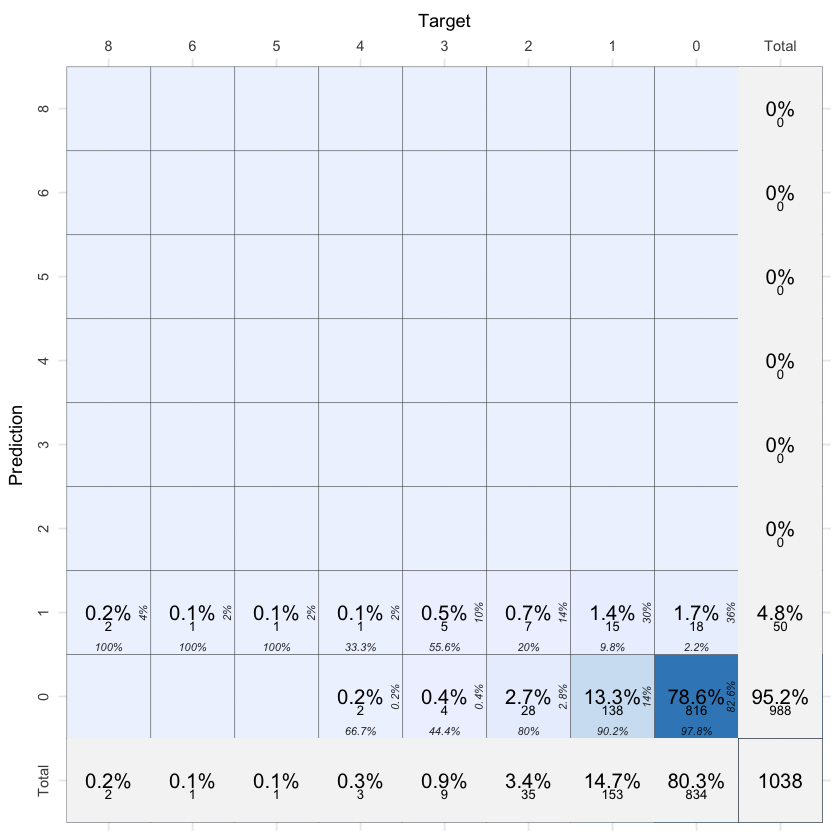

In [269]:
# Prediction for test set 
pred_poisson_penalized <- round(predict(model_poisson, newx = x_test, type = "response"), 0)

# Classification table
tab_1 <- table(test$visits, pred_poisson_penalized)

# test MSE
cat("The test mean squared error is:", mean((test$visits - pred_poisson_penalized)^2), "\n")
# Classification rate
cat("The mis-classification rate is:", 1-sum(diag(tab_1))/nrow(test))

# Confusion matrix 
conf_matrix_pp <- confusion_matrix(targets = test$visits,
                             predictions = pred_poisson_penalized)

plot_confusion_matrix(conf_matrix_pp$`Confusion Matrix`[[1]],
                      add_sums = TRUE, tile_border_color = "black", sums_settings = sum_tile_settings(
                        label = "Total",
            tc_tile_border_color = "black"))


### Full Poisson Model Selection and Prediction

Next, we fit the full Poisson model without any penalization and use this for prediction. 

In [237]:
# Full poisson model 
full_poisson_model <- glm(visits~.,data= train,family= 'poisson')

summary(full_poisson_model)


Call:
glm(formula = visits ~ ., family = "poisson", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9155  -0.6859  -0.5759  -0.4879   5.6670  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.166299   0.113782 -19.039  < 2e-16 ***
genderfemale  0.165156   0.062928   2.625  0.00868 ** 
age           0.396849   0.183864   2.158  0.03090 *  
income       -0.141807   0.094519  -1.500  0.13354    
illness       0.174245   0.020335   8.569  < 2e-16 ***
reduced       0.128031   0.005537  23.121  < 2e-16 ***
health        0.033773   0.010996   3.071  0.00213 ** 
privateyes    0.153800   0.080936   1.900  0.05740 .  
freepooryes  -0.250312   0.187549  -1.335  0.18199    
freerepatyes  0.123243   0.103478   1.191  0.23365    
nchronicyes   0.106914   0.074209   1.441  0.14966    
lchronicyes   0.046001   0.092350   0.498  0.61840    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter

The test mean squared error is: 0.4807322 
The mis-classification rate is: 0.2013487

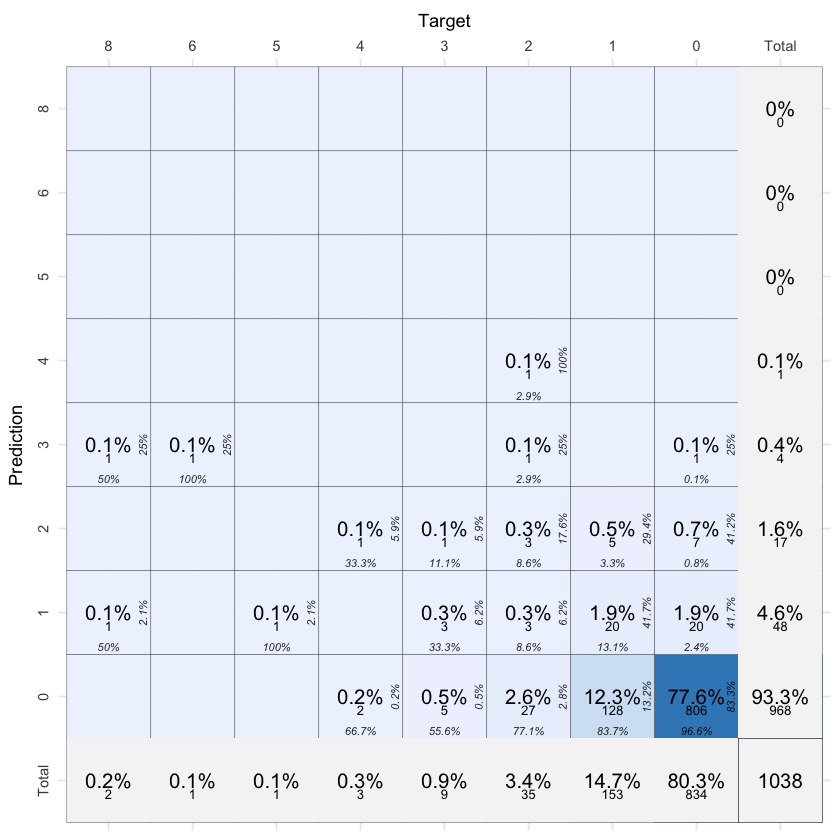

In [240]:
# Prediction for test set 
pred_poisson <- round(predict(full_poisson_model, newdata = test[, -1], type = "response"), 0)

# Classification table
tab_2 <- table(test$visits, pred_poisson)

# test MSE
cat("The test mean squared error is:", mean((test$visits - pred_poisson)^2), "\n")
# Classification rate
cat("The mis-classification rate is:", 1-sum(diag(tab_2))/nrow(test))

# Confusion matrix 
conf_matrix_pp_full <- confusion_matrix(targets = test$visits,
                             predictions = pred_poisson)

plot_confusion_matrix(conf_matrix_pp_full$`Confusion Matrix`[[1]],
                      add_sums = TRUE, tile_border_color = "black", sums_settings = sum_tile_settings(
                        label = "Total",
            tc_tile_border_color = "black"))


## Negative-Binomial Model

For the negative binomial model, we start by predicting from the full model. We do so, as we wish to use the value of $\theta$ estimated for the full model from the training set for the penalized model as well. Naturally, this is not the ideal approach, as the most appropriate method would be to estimate $\theta$ while the penalized model is fit. However, this would be somewhat more computationally intensive, which is why the former method was opted for. 

### Full Model Selection and Prediction

In [241]:
# Full NB model 
visits.nb <- glm.nb(visits ~., data = train)


summary(visits.nb)


Call:
glm.nb(formula = visits ~ ., data = train, init.theta = 0.8920520455, 
    link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9379  -0.6351  -0.5251  -0.4370   3.9483  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.367388   0.138894 -17.045  < 2e-16 ***
genderfemale  0.208809   0.078714   2.653  0.00798 ** 
age           0.423087   0.232963   1.816  0.06935 .  
income       -0.094497   0.116086  -0.814  0.41563    
illness       0.208978   0.026415   7.911 2.55e-15 ***
reduced       0.143944   0.008136  17.693  < 2e-16 ***
health        0.040839   0.015032   2.717  0.00659 ** 
privateyes    0.154866   0.097339   1.591  0.11161    
freepooryes  -0.295881   0.223670  -1.323  0.18589    
freerepatyes  0.216911   0.131067   1.655  0.09793 .  
nchronicyes   0.093817   0.089094   1.053  0.29233    
lchronicyes   0.117730   0.116316   1.012  0.31146    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘

The test mean squared error is: 0.495183 
The mis-classification rate is: 0.2013487

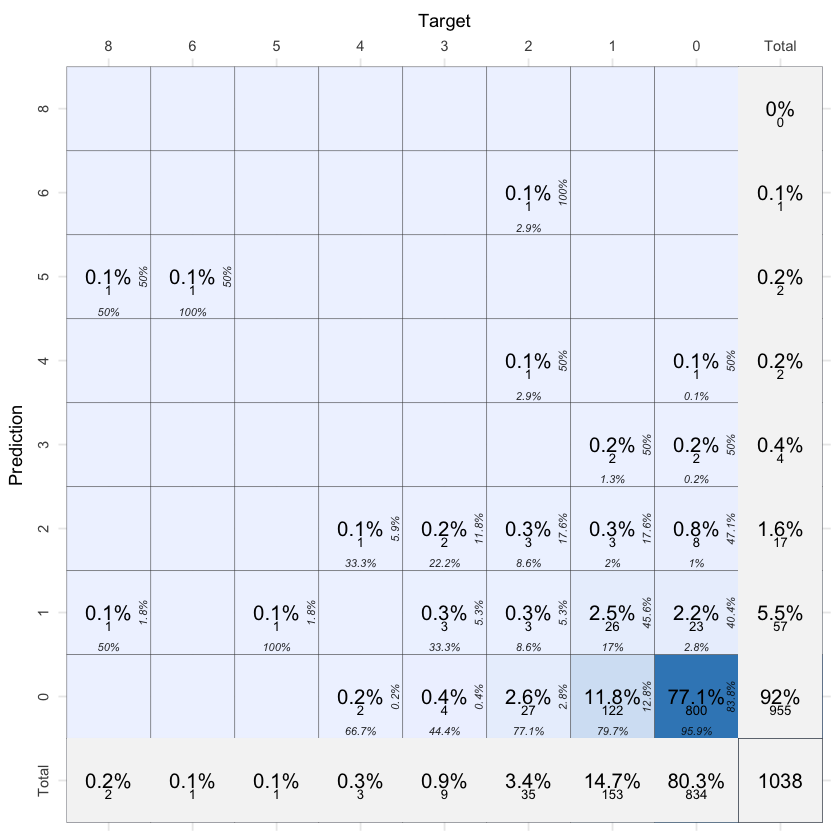

In [242]:
# Prediction for test set 
pred_nb <- round(predict(visits.nb, newdata = test[, -1], type = "response"), 0)

# Classification table
tab_3 <- table(test$visits, pred_nb)

# test MSE
cat("The test mean squared error is:", mean((test$visits - pred_nb)^2), "\n")
# Classification rate
cat("The mis-classification rate is:", 1-sum(diag(tab_3))/nrow(test))

# Confusion matrix 
conf_matrix_nb_full <- confusion_matrix(targets = test$visits,
                             predictions = pred_nb)

plot_confusion_matrix(conf_matrix_nb_full$`Confusion Matrix`[[1]],
                      add_sums = TRUE, tile_border_color = "black", sums_settings = sum_tile_settings(
                        label = "Total",
            tc_tile_border_color = "black"))

### Penalized Model Selection and Prediction

In [243]:
# CV for all-three pre-defined values of alpha
cv02_nb <- cv.glmnet(x_train, train$visits, foldid = foldid, alpha = 0.2, family =  
                     negative.binomial(theta = 0.892),
                 nfold = 10, parallel = TRUE, type.measure = "mse")
cv05_nb <- cv.glmnet(x_train, train$visits, foldid = foldid, alpha = 0.5, 
                family =  negative.binomial(theta = 0.892), nfold = 10, parallel = TRUE, type.measure = "mse")
cv07_nb  <- cv.glmnet(x_train, train$visits, foldid = foldid, alpha = 0.7, 
                  family =  negative.binomial(theta = 0.892), nfold = 10,  parallel = TRUE,type.measure = "mse")

cv02_nb ; cv05_nb ; cv07_nb


Call:  cv.glmnet(x = x_train, y = train$visits, type.measure = "mse",      nfolds = 10, foldid = foldid, parallel = TRUE, alpha = 0.2,      family = negative.binomial(theta = 0.892)) 

Measure: Mean-Squared Error 

    Lambda Index Measure      SE Nonzero
min 0.1141    27  0.5606 0.03785       7
1se 0.3176    16  0.5954 0.03647       4


Call:  cv.glmnet(x = x_train, y = train$visits, type.measure = "mse",      nfolds = 10, foldid = foldid, parallel = TRUE, alpha = 0.5,      family = negative.binomial(theta = 0.892)) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.06623    23  0.5592 0.03750       5
1se 0.18428    12  0.5948 0.03594       2


Call:  cv.glmnet(x = x_train, y = train$visits, type.measure = "mse",      nfolds = 10, foldid = foldid, parallel = TRUE, alpha = 0.7,      family = negative.binomial(theta = 0.892)) 

Measure: Mean-Squared Error 

     Lambda Index Measure      SE Nonzero
min 0.05192    22  0.5592 0.03733       4
1se 0.14447    11  0.5947 0.03576       2

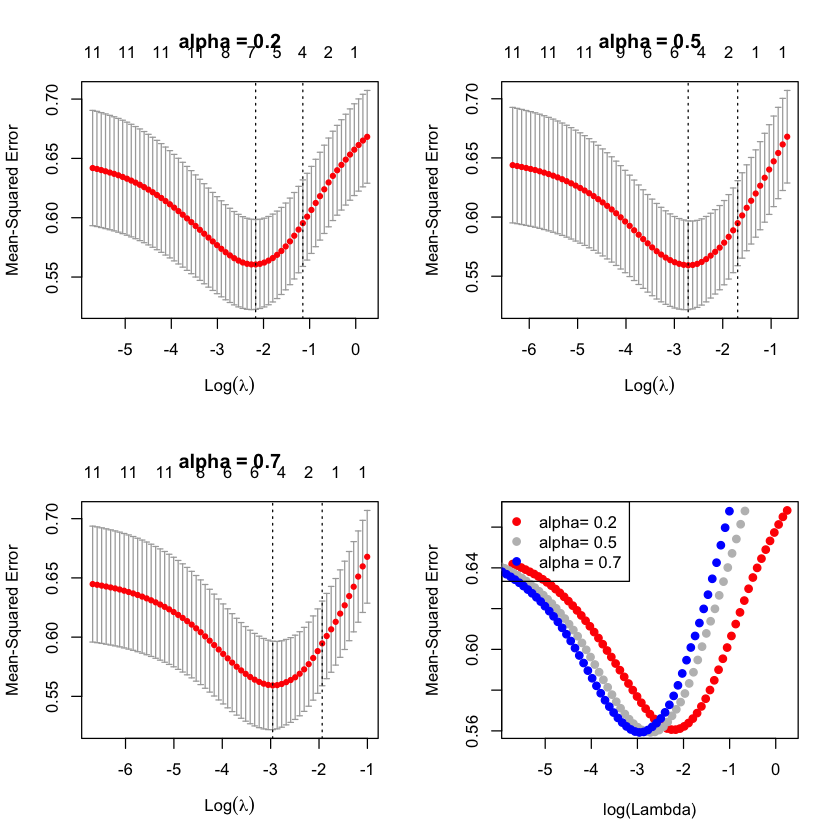

In [205]:
# Visualizing tuning of lambda for different alphas 
# Adapted directly from the glmnet vignette
par(mfrow = c(2,2))
plot(cv02_nb, main = "alpha = 0.2"); plot(cv05_nb, main = "alpha = 0.5"); plot(cv07_nb, main = "alpha = 0.7")
plot(log(cv02_nb$lambda)   , cv02_nb$cvm , pch = 19, col = "red",
     xlab = "log(Lambda)", ylab = cv02_nb$name)
points(log(cv05_nb$lambda), cv05_nb$cvm, pch = 19, col = "grey")
points(log(cv07_nb$lambda) , cv07_nb$cvm , pch = 19, col = "blue")
legend("topleft", legend = c("alpha= 0.2", "alpha= 0.5", "alpha = 0.7"),
       pch = 19, col = c("red","grey","blue"))

We see that the lowest MSE for the $\lambda$1.se (0.14447) was achieved for $\alpha = 0.7$, with a training MSE of 0.5947. This can now be used to predict for our test set. 

In [244]:
# Coefficients selected by best model in training set
model_nb <- glmnet(x_train, train$visits, family = negative.binomial(theta = 0.892), lambda = cv07_nb$lambda.1se,
                        alpha = 0.7)
coef(model_nb)

12 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept)  -1.39440733
age           .         
reduced       0.09437198
illness       0.01279223
income        .         
health        .         
privateyes    .         
freepooryes   .         
freerepatyes  .         
nchronicyes   .         
lchronicyes   .         
genderfemale  .         

In the negative-binomial model which we will use to predict on the test set, we see that the same two 
coefficients have been shrunk to zero except for the variables `reduced` and `Illness`

The test mean squared error is: 0.5231214 
The mis-classification rate is: 0.1984586

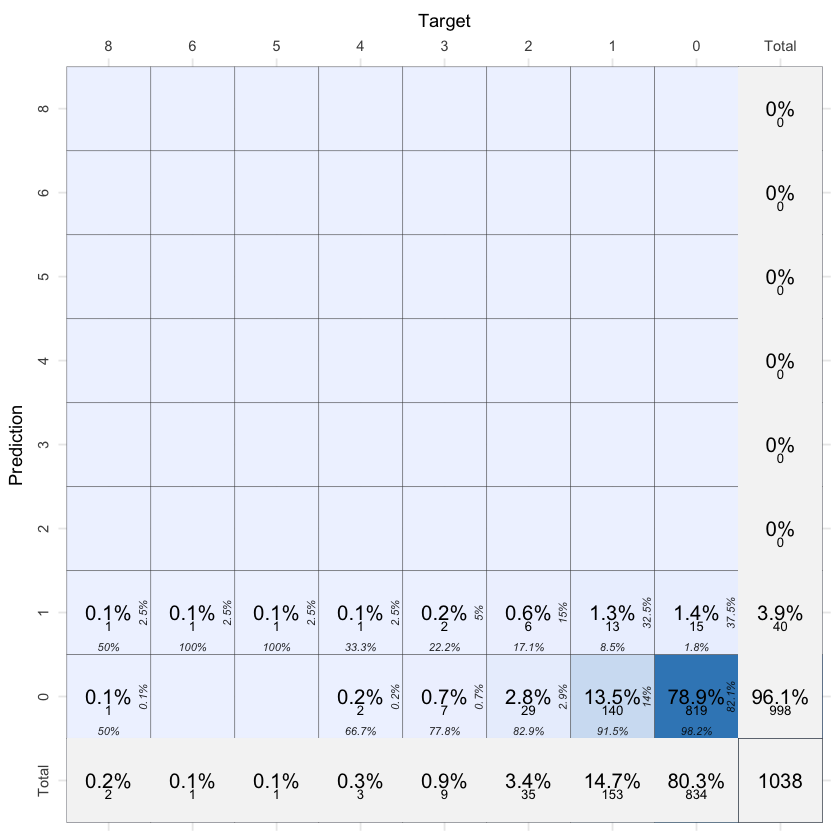

In [245]:
# Prediction for test set 
pred_nb_penalized <- round(predict(model_nb, newx = x_test, type = "response"), 0)

# Classification table
tab_4 <- table(test$visits, pred_nb_penalized)

# test MSE
cat("The test mean squared error is:", mean((test$visits - pred_nb_penalized)^2), "\n")
# Classification rate
cat("The mis-classification rate is:", 1-sum(diag(tab_4))/nrow(test))

# Confusion matrix 
conf_matrix_nb_penalized <- confusion_matrix(targets = test$visits,
                             predictions = pred_nb_penalized)

plot_confusion_matrix(conf_matrix_nb_penalized$`Confusion Matrix`[[1]],
                      add_sums = TRUE, tile_border_color = "black", sums_settings = sum_tile_settings(
                        label = "Total",
            tc_tile_border_color = "black"))

# Zero-inflated Poisson Model

## Full Model Selection and Prediction

In [196]:
# Full zero-inflated negative binomial model with all predictor variables 
model_zeroinf <- pscl::zeroinfl(visits~ .|., data= train, dist= "poisson")

summary(model_zeroinf)


Call:
pscl::zeroinfl(formula = visits ~ . | ., data = train, dist = "poisson")

Pearson residuals:
    Min      1Q  Median      3Q     Max 
-1.5676 -0.4540 -0.2920 -0.1897 11.7836 

Count model coefficients (poisson with log link):
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.682494   0.162127  -4.210 2.56e-05 ***
genderfemale  0.058343   0.079048   0.738   0.4605    
age           0.245736   0.236239   1.040   0.2982    
income       -0.118007   0.121887  -0.968   0.3330    
illness       0.020345   0.027473   0.741   0.4590    
reduced       0.084996   0.006609  12.860  < 2e-16 ***
health        0.029221   0.012317   2.372   0.0177 *  
privateyes   -0.044565   0.108113  -0.412   0.6802    
freepooryes  -0.214605   0.248626  -0.863   0.3880    
freerepatyes -0.196476   0.131318  -1.496   0.1346    
nchronicyes  -0.044062   0.103667  -0.425   0.6708    
lchronicyes  -0.134211   0.113548  -1.182   0.2372    

Zero-inflation model coefficients (binomial with lo

The test mean squared error is: 0.4585742 
The mis-classification rate is: 0.2023121

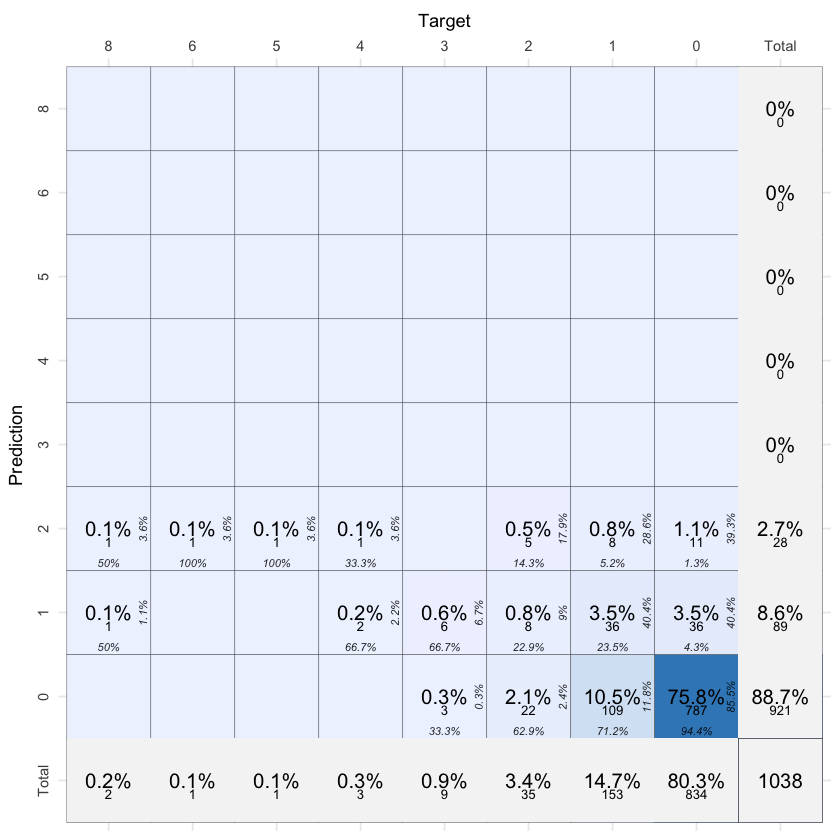

In [246]:
# Prediction for test set 
pred_zeroinf <- round(predict(model_zeroinf, newdata = test[,-1], type = "response"), 0)

# Classification table
tab_5 <- table(test$visits, pred_zeroinf)

# test MSE
cat("The test mean squared error is:", mean((test$visits - pred_zeroinf )^2), "\n")
# Classification rate
cat("The mis-classification rate is:", 1-sum(diag(tab_5))/nrow(test))

# Confusion matrix 
conf_matrix_zip_full <- confusion_matrix(targets = test$visits,
                             predictions = pred_zeroinf)

plot_confusion_matrix(conf_matrix_zip_full$`Confusion Matrix`[[1]],
                      add_sums = TRUE, tile_border_color = "black", sums_settings = sum_tile_settings(
                        label = "Total",
            tc_tile_border_color = "black"))

## Penalized Model Selection and Prediction

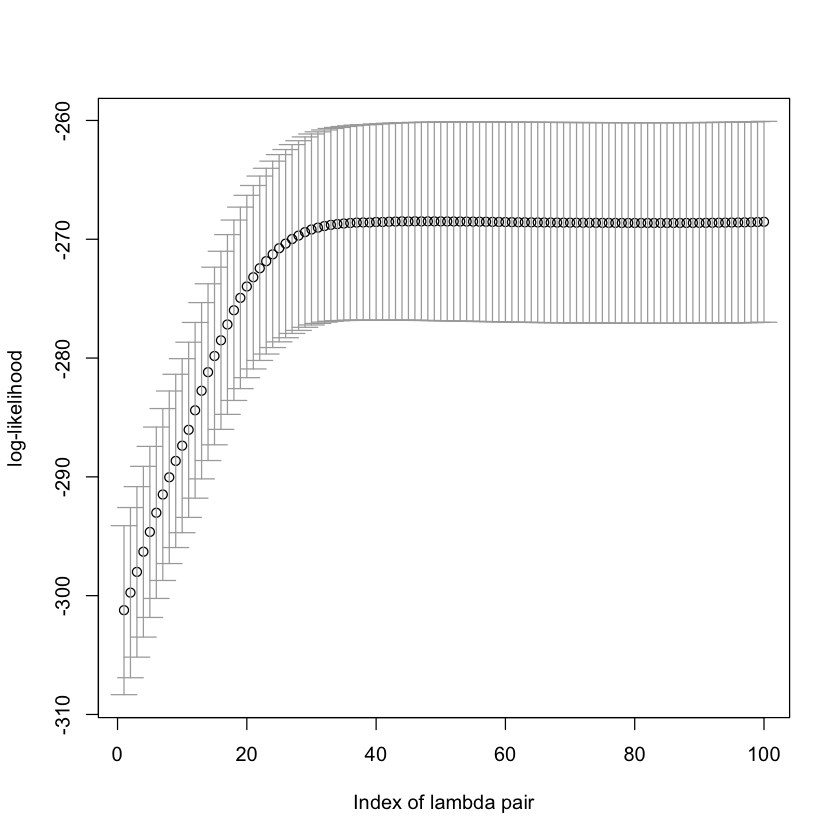

In [316]:
# Formatting folds for mpath
id <- seq_len(nrow(train))

dat_folds <- data.frame(cbind(id, foldid))

foldid3 <- split(dat_folds$id, dat_folds$foldid)

# Penalized zero-inflated poisson 
zip_fit_1 <- cv.zipath(visits ~ . | ., data = train, family = "poisson", 
                      nfolds = 10, 
                         foldid = foldid3, 
                          alpha.count = 0.2,  maxit.em=300, 
                         penalty = "enet", 
                       rescale = FALSE)

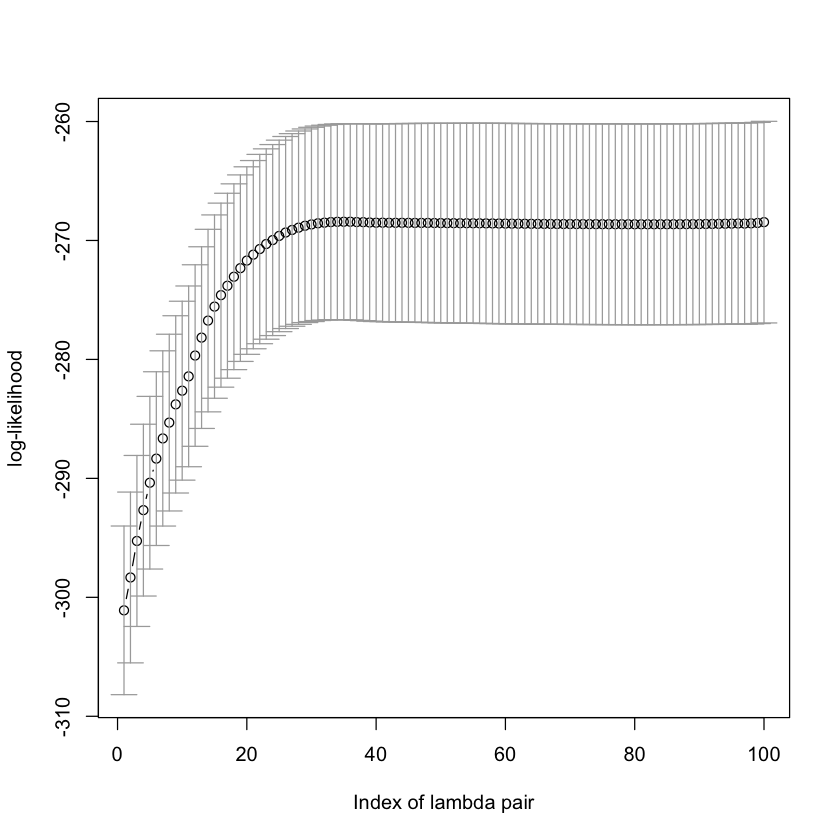

In [317]:
# For 0.5
zip_fit_2 <- cv.zipath(visits ~ . | ., data = train, family = "poisson", 
                      nfolds = 10, 
                         foldid = foldid3, 
                         alpha.count = 0.5, maxit.em=300, 
                         penalty = "enet", 
                       rescale = FALSE)

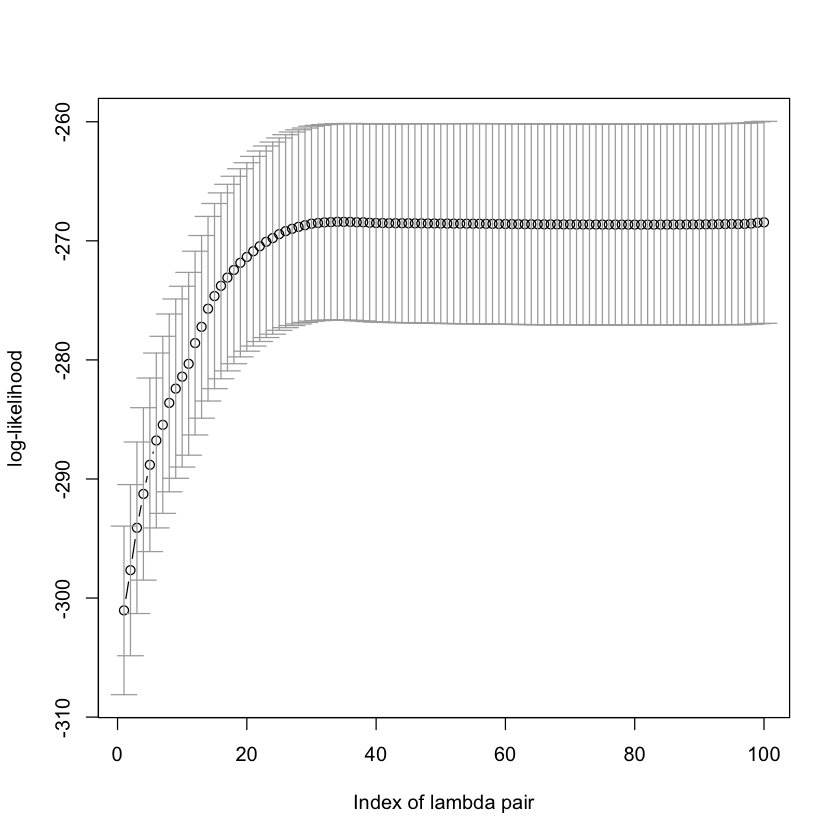

In [318]:
# For 0.7
zip_fit_3 <- cv.zipath(visits ~ . | ., data = train, family = "poisson", 
                      nfolds = 10, alpha.count = 0.7, 
                         foldid = foldid3,  penalty = "enet", maxit.em=300, 
                       rescale = FALSE)

In [324]:
# Log-likelihood and optimal lambdas selected
cat("The log-likelihood for alpha = 0.2:" ,max(zip_fit_1$cv), "\n")

cat("The log-likelihood for alpha = 0.5:" ,max(zip_fit_2$cv), "\n")

cat("The log-likelihood for alpha = 0.7:" ,max(zip_fit_3$cv), "\n")

# Optimal lambda
zip_fit_3$lambda.optim

The log-likelihood for alpha = 0.2: -268.4885 
The log-likelihood for alpha = 0.5: -268.4262 
The log-likelihood for alpha = 0.7: -268.4001 


$count
[1] 0.01697075

$zero
[1] 0.06607765

We see that the highest log-likelihood (-268.4001) for the $\lambda$1.se for the zero and count processes was achieved for $\alpha = 0.7$. This was the same mixing parameter chosen for the negative binomial model. This can now be used to predict for our test set.

In [326]:
# Fitting the penalized model for prediction 
zip_fitp <- zipath(visits ~ . | ., data = train, family = "poisson", 
                      nfolds = 10, alpha.count = 0.7,  
                    lambda.count = zip_fit_3$lambda.optim$count, 
                    lambda.zero = zip_fit_3$lambda.optim$zero, 
                      maxit.em=300,  penalty = "enet", 
                       rescale = FALSE)

summary(zip_fitp)


Call:
zipath.formula(formula = visits ~ . | ., data = train, family = "poisson", 
    nfolds = 10, alpha.count = 0.7, lambda.count = zip_fit_3$lambda.optim$count, 
    lambda.zero = zip_fit_3$lambda.optim$zero, maxit.em = 300, penalty = "enet", 
    rescale = FALSE)


Count model coefficients (poisson with log link):
             [,1]  
(Intercept)  -1.645
genderfemale  0.149
age           0.473
income       -0.033
illness       0.173
reduced       0.124
health        0.022
privateyes    0.000
freepooryes   0.000
freerepatyes  0.000
nchronicyes   0.019
lchronicyes   0.000

Zero-inflation model coefficients (binomial with logit link):
             [,1]  
(Intercept)  -0.605
genderfemale  0.000
age           0.000
income        0.000
illness       0.000
reduced       0.000
health        0.000
privateyes    0.000
freepooryes   0.000
freerepatyes  0.000
nchronicyes   0.000
lchronicyes   0.000

Log-likelihood: -2671 

In the zero-inflated Poisson model which we will use to predict on the test set, we see that in the Poisson model, 
the variables that were not shrinked to zero were `gender`, `age`, `income`, `illness`, `reduced`, `health` and `nchronic`. Interestingly, in the binomial model, all the coefficients were shrinked to zero.

The test mean squared error is: 0.4807322 
The mis-classification rate is: 0.1974952

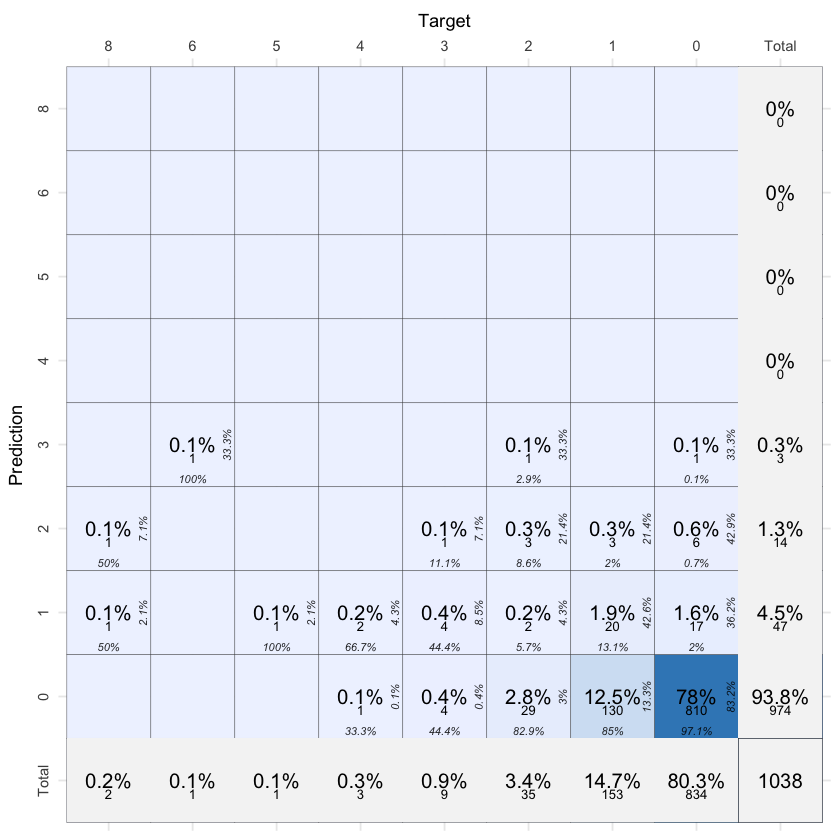

In [327]:
# Prediction for test set 
pred_zeroinf_p <- round(predict(zip_fitp, newdata = test[,-1], type = "response"), 0)

# Classification table
tab_6 <- table(test$visits, pred_zeroinf_p)

# test MSE
cat("The test mean squared error is:", mean((test$visits - pred_zeroinf_p )^2), "\n")
# Classification rate
cat("The mis-classification rate is:", 1-sum(diag(tab_6))/nrow(test))

# Confusion matrix 
conf_matrix_zip_p <- confusion_matrix(targets = test$visits,
                             predictions = pred_zeroinf_p)

plot_confusion_matrix(conf_matrix_zip_p$`Confusion Matrix`[[1]],
                      add_sums = TRUE, tile_border_color = "black", sums_settings = sum_tile_settings(
                        label = "Total",
            tc_tile_border_color = "black"))

We can summarize our results as follows: 

|                             | MSE       | mis-classification rate | % of zeros predicted | classes predicted |
|-----------------------------|-----------|-------------------------|----------------------|-------------------|
| poisson penalized           | 0.4922929 | 0.199422                | 78.6%                | 0-2               |
| poisson full                | 0.4807322 | 0.2013487               | 77.6%                | 0-4               |
| negative binomial penalized | 0.5231214 | 0.1984586               | 78.9%                | 0-1               |
| negative binomial full      | 0.495183  | 0.2013487               | 77.1%                | 0-6               |
| ZIP penalized               | 0.4807322 | 0.1974952               | 78%                  | 0-3               |
| ZIP full                    | 0.4585742 | 0.2023121               | 75.8%                | 0-2               |

# Discussion

The aim of this project was to build a reasonable prediction model for the number of doctor visits. Specifically, a reasonable prediction model would be able to handle zero-inflation (which such data is prone to), but also predict a higher number of visits. 

Looking at the penalized poisson model fit, the lowest MSE was achieved for an $\alpha$ of 0.5, which indicates that the ideal penalty is an even mix between the lasso and ridge penalties. However for the penalized negative binomial fit and the zero-inflated poisson fit, the lowest MSE was achieved for an $\alpha$ of 0.7, which leans more towards a lasso regression. The preference of the latter two models towards an $\alpha = 0.7$ could be that there were no extremely highly correlations between any of the covariates, and thus, the predictive power is maximized by shrinking variables completely to zero. 

Recalling our exploratory data analysis, we saw that `age`, `reduced`, `gender`, `Illness`, `freerepat`, `nchronic` and `lchronic` seemed to be important explanatory variables. This is retained to a very high extent by the count portion of the zero-inflated poisson model, which selected all of these variables except `reduced`, `freerepat` and `lchronic` (could have been shrinked due to the high correlation between `lchronic` and `nchronic`) and additionally selected `health`. However, the binomial model of the zero-inflated model shrunk all the coefficients to zero. A much more sparse selection was made by the negative binomial and poisson models, with the former selecting only `reduced` and `Illness` and the latter only `reduced`.

In general, comparing between the full and the reduced models, the predictions of all the full models seem to have a lower mean squared error compared to the penalized model. However, the penalized models have a lower mis-classification rate compared to the full models. 

Looking at the % of zeroes predicted for all the models, we see that the penalized models always accurately predict a higher number of zeroes. However, with the expection of the zero-inflated poisson, the other full models tend to be able to predict the higher counts of visits, which the penalized models cannot seem to do. A possible reason why this is the case is that the penalized models for the poisson and negative binomial sparsely shrink to the variables that largely explain the zero observations and not the higher counts. 

In general, a limitation of this predictive problem is the high proportion of zeroes in the dataset, which makes the prediction of the higher counts a challenging task for all the models. If the measure of performance is predicting higher counts, it is the full negative binomial model that performs the best in this aspect. This may be due to the fact that it is able to account for overdispersion in the response, which we also considered in our exploratory analysis. However, looking at the mean squared error, it is the zero-inflated poisson that is able to predict the zeroes and ones (the lower counts) relatively more accurately. 

For future work, this problem can also be successfully addressed as binary classification one, where the task is solely to predict two categories: zero and non-zero categories, as this would increase the sample size for the non-zero counts. 

Overall however, all the models attempted in this project are able to predict the number of doctor visits to an extent. These models recover the proportion of zeroes quite well, with the best performance for higher counts shown by the negative binomial model. Further work can be done to solely improve the prediction of the negative binomial model, such as letting the $\theta$ (shape) parameter be estimated from each of the cross-validation folds. It may also be interesting to attempt a zero-inflated negative binomial as well, which can account for both overdispersion and an excess of zeroes. Lastly, in order to better compare the predictive ability of these models, repeated cross-validations should be done and the error curves averaged, in order to minimize the role of random chance due to splits in the predictve results. More carefully stratified splits with the higher counts can also be done to increase predictive ability. 

## References 

Wang, Z., Ma, S., & Wang, C. Y. (2015). Variable selection for zero-inflated and overdispersed data with application to health care demand in Germany. Biometrical journal. Biometrische Zeitschrift, 57(5), 867–884. https://doi.org/10.1002/bimj.201400143

Cameron, A.C. and Trivedi, P.K. (1986). Econometric Models Based on Count Data: Comparisons and Applications of Some Estimators and Tests. Journal of Applied Econometrics, 1, 29–53.

Cameron, A.C. and Trivedi, P.K. (1998). Regression Analysis of Count Data. Cambridge: Cambridge University Press.

Mullahy, J. (1997). Heterogeneity, Excess Zeros, and the Structure of Count Data Models. Journal of Applied Econometrics, 12, 337–350.
